# Markov Chain Implementation - TensorFlow

In [128]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sn

import tensorflow as tf

In [2]:
tf.__version__

'2.3.0'

# TensorFlow Data Types

Basic data types for linear algebra are the scaler, vector, matrix, and multidimentional matrix. The following code shows how to do all of this in TF definitions

In [3]:
a = tf.constant(5.0, dtype=tf.float32)
a

<tf.Tensor: shape=(), dtype=float32, numpy=5.0>

In [4]:
x = tf.constant([1,2,4,5])
x

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([1, 2, 4, 5], dtype=int32)>

In [5]:
y = tf.constant([[1,2,3,4],
                 [5,6,7,8]]) 
y

<tf.Tensor: shape=(2, 4), dtype=int32, numpy=
array([[1, 2, 3, 4],
       [5, 6, 7, 8]], dtype=int32)>

In [6]:
sequence = tf.range(start = 1,limit = 10, delta = 1)
sequence

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>

In [7]:
z = tf.constant(tf.range(1,13), shape = (2,3,2))
z

<tf.Tensor: shape=(2, 3, 2), dtype=int32, numpy=
array([[[ 1,  2],
        [ 3,  4],
        [ 5,  6]],

       [[ 7,  8],
        [ 9, 10],
        [11, 12]]], dtype=int32)>

In [8]:
variable_mat = tf.Variable(tf.constant(tf.range(12, dtype = tf.float32), shape = (3,4)))
variable_mat

<tf.Variable 'Variable:0' shape=(3, 4) dtype=float32, numpy=
array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.]], dtype=float32)>

# Business Case for Markov Chains

The business case that will be explored here is the Kanky Loan system. In this system there are 4 types of loans:

1. Good Loans - outstanding money which will most likely be paid out
1. Risky Loans - outstanding money which will most likely NOT be paid out
1. Paid Up Loans - loans which were paid out
1. Bad Loans -  loans which were not paid out

The interations of the loans can be described as the picture below.

<img src="loans_int.png" alt="Drawing" style="width: 600px;"/>

The system describes a time transient system in which certain states are constantly changing. This type of system is common across many industries and use cases. 

Markov chains are a great way to model this system because they allow for someone to specify the two values 1) state and 2) probability in a linear fashion. The following code implements this system from scratch in TensorFlow.

# Markov Chain Application

## Defining Base Vector and Matrix
X will be the probability matrix and y will be the state vector in this case. y is defined as [Good, Risky, Bad, Paid up]

In [9]:
X = [
     [0.7 , 0.05, 0.03, 0.22,],
     [0.05, 0.55, 0.35, 0.05,],
     [0.0 , 0.0 , 1.0 , 0.0 ,],
     [0.0 , 0.0 , 0.0 , 1.0 ,],
    ]
X = tf.transpose(tf.constant(X))
y = tf.constant([0.5, 0.5, 0.0, 0.0], shape = (4,1))

## Taking a Markov Step

In [10]:
y_new = tf.matmul(a=X, b=y)
y_new.numpy()

array([[0.375],
       [0.3  ],
       [0.19 ],
       [0.135]], dtype=float32)

## Simulating All Loan Pay Outs

In [70]:
def simulate_loan_markov_chain(X, y):

    bad = tf.constant(y[2])
    paid_up = tf.constant(y[3])
    
    while (y[0].numpy()[0] > 1e-4 and y[1].numpy()[0] > 1e-3):
        
        y = tf.matmul(a=X, b=y)
        
        bad = tf.concat([bad, y[2]],0)
        paid_up = tf.concat([paid_up, y[3]],0)
        
    return bad, paid_up

bad, paid_up = simulate_loan_markov_chain(X, y)

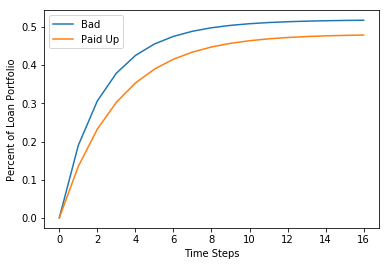

In [71]:
fig, ax = plt.subplots()
ax.plot(bad, label='Bad')
ax.plot(paid_up, label='Paid Up')
ax.legend()
ax.set_xlabel('Time Steps')
ax.set_ylabel('Percent of Loan Portfolio')
plt.show()

# Markov Chain Monte Carlo

The addition of random vairance to the Markov Chain model can be a powerful tool to understand how time series steps can be influenced from a probabilistic perspective.

## Defining Standard Deviations

In [13]:
X = [
     [0.7 , 0.05, 0.03, 0.22,],
     [0.05, 0.55, 0.35, 0.05,],
     [0.0 , 0.0 , 1.0 , 0.0 ,],
     [0.0 , 0.0 , 0.0 , 1.0 ,],
    ]
X = tf.transpose(tf.constant(X))
X_std = [
     [0.1 , 0.01, 0.01, 0.05,],
     [0.01, 0.1 , 0.05, 0.01,],
     [0.0 , 0.0 , 0.0 , 0.0 ,],
     [0.0 , 0.0 , 0.0 , 0.0 ,],
    ]
X_std = tf.transpose(tf.constant(X_std))
y = tf.constant([0.5, 0.5, 0.0, 0.0], shape = (4,1))

In [62]:
X_rand = np.random.normal(0, 1, X.shape) * X_std + X
X_rand = tf.keras.utils.normalize(
    X_rand, axis=0, order=1
)
X_rand

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.7045243 , 0.05196859, 0.        , 0.        ],
       [0.04436144, 0.51158106, 0.        , 0.        ],
       [0.04080195, 0.38617215, 1.        , 0.        ],
       [0.21031228, 0.05027815, 0.        , 1.        ]], dtype=float32)>

## Simulation Function

In [118]:
def simulate_loan_markov_chain_monte_carlo(X, X_std, y):

    bad = tf.constant(y[2])
    paid_up = tf.constant(y[3])
    
    X_rand = np.random.normal(0, 1, X.shape) * X_std + X
    X_rand = tf.keras.utils.normalize(
        X_rand, axis=0, order=1
    )
    
    while (y[0].numpy()[0] > 1e-4 and y[1].numpy()[0] > 1e-3):
        
        y = tf.matmul(a=X_rand, b=y)
        
        bad = tf.concat([bad, y[2]],0)
        paid_up = tf.concat([paid_up, y[3]],0)
        
    return bad, paid_up

def mcmc_sampling(X, X_std, y, threads = 10):
    
    bad_all = tf.Variable(np.zeros(threads))
    paid_up_all = tf.Variable(np.zeros(threads))
    for thread in range(threads):
        bad, paid_up = simulate_loan_markov_chain_monte_carlo(X, X_std, y)
        bad_all = bad_all[thread].assign(bad.numpy()[-1])
        paid_up_all = paid_up_all[thread].assign(paid_up.numpy()[-1])
    return bad_all, paid_up_all

bad, paid_up = simulate_loan_markov_chain_monte_carlo(X, X_std, y)
bad_all, paid_up_all = mcmc_sampling(X, X_std, y, threads = 1000)

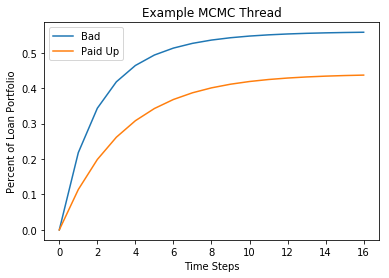

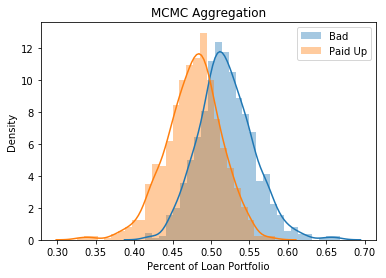

In [131]:
fig, ax = plt.subplots()
ax.plot(bad, label='Bad')
ax.plot(paid_up, label='Paid Up')
ax.legend()
ax.set_xlabel('Time Steps')
ax.set_ylabel('Percent of Loan Portfolio')
ax.set_title('Example MCMC Thread')
plt.show()

fig, ax = plt.subplots()
sn.distplot(bad_all.numpy(), label='Bad', ax=ax)
sn.distplot(paid_up_all.numpy(), label='Paid Up', ax=ax)
ax.legend()
ax.set_ylabel('Density')
ax.set_xlabel('Percent of Loan Portfolio')
ax.set_title('MCMC Aggregation')
plt.show()